## Plot posteriors for a single star

In [15]:
import os
default_n_threads = 1
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax
import lsdb
import matplotlib.pyplot as plt
import nested_pandas as npd
import numpy as np
import pandas as pd

from scipy.interpolate import griddata
from photod.bayes import makeBayesEstimates3d
from photod.locus import LSSTsimsLocus, subsampleLocusData, get3DmodelList
from photod.parameters import GlobalParams

In [16]:
s82_stripe_url = "/mnt/beegfs/scratch/data/S82_standards/S82_hats/S82_hats_fixed"
s82_stripe_catalog = lsdb.read_hats(s82_stripe_url)
s82_stripe_catalog

,CALIBSTARS,ra,dec,RArms,Decrms,Ntot,Ar,uNobs,umag,ummu,uErr,umrms,umchi2,gNobs,gmag,gmmu,gErr,gmrms,gmchi2,rNobs,rmag,rmmu,rErr,rmrms,rmchi2,iNobs,imag,immu,iErr,imrms,imchi2,zNobs,zmag,zmmu,zErr,zmrms,zmchi2,Norder,Dir,Npix,Mr,FeH,MrEst,MrEstUnc,FeHEst,ug,gr,gi,ri,iz,ugErr,grErr,giErr,riErr,izErr,glon,glat
npartitions=7,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 4, Pixel: 0",string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int8[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
"Order: 4, Pixel: 768",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 4, Pixel: 2303",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 4, Pixel: 3071",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [17]:
prior_map_url = "/mnt/beegfs/scratch/data/priors/hats/s82_priors"
prior_map_catalog = lsdb.read_hats(prior_map_url)
prior_map_catalog

,rmag,kde,xGrid,yGrid,Norder,Dir,Npix
npartitions=207,,,,,,,
"Order: 5, Pixel: 0",double[pyarrow],binary[pyarrow],binary[pyarrow],binary[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 5, Pixel: 1",...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12286",...,...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...,...


In [18]:
# locus_path = "/home/scampos/photoD/data/MSandRGBcolors_v1.3.txt"
locus_path = "../../data/MSandRGBcolors_v1.3.txt"
fitColors = ("ug", "gr", "ri", "iz")
LSSTlocus = LSSTsimsLocus(fixForStripe82=False, datafile=locus_path)
OKlocus = LSSTlocus[(LSSTlocus["gi"] > 0.2) & (LSSTlocus["gi"] < 3.55)]
locusData = subsampleLocusData(OKlocus, kMr=10, kFeH=2)
ArGridList, locus3DList = get3DmodelList(locusData, fitColors)
globalParams = GlobalParams(fitColors, locusData, ArGridList, locus3DList)

subsampled locus 2D grid in FeH and Mr from 51 1559 to: 25 155


In [36]:
def makeBayesEstimatesSingleStar(partition, map_partition, globalParams):
    priorGrid = {}
    print(f"Map partition: {map_partition}") # 
    for rind, r in enumerate(np.sort(map_partition["rmag"].to_numpy())):
        # interpolate prior map onto locus Mr-FeH grid
        Z = map_partition[map_partition["rmag"] == r]
        # print(Z) #
        Zval = np.frombuffer(Z.iloc[0]["kde"], dtype=np.float64).reshape((96, 36))
        X = np.frombuffer(Z.iloc[0]["xGrid"], dtype=np.float64).reshape((96, 36))
        Y = np.frombuffer(Z.iloc[0]["yGrid"], dtype=np.float64).reshape((96, 36))
        points = np.array((X.flatten(), Y.flatten())).T
        values = Zval.flatten()
        # actual (linear) interpolation
        priorGrid[rind] = griddata(
            points, values, (globalParams.locusData["FeH"], globalParams.locusData[globalParams.MrColumn]), method="linear", fill_value=0
        )
    priorGrid = jax.numpy.array(list(priorGrid.values()))
    _, results = makeBayesEstimates3d(partition, priorGrid, globalParams, returnAllInfo=True)
    return results


In [37]:
stars_df = s82_stripe_catalog.partitions[3].compute()[193:195]
stars_df

,CALIBSTARS,ra,dec,RArms,Decrms,Ntot,Ar,uNobs,umag,ummu,...,gi,ri,iz,ugErr,grErr,giErr,riErr,izErr,glon,glat
_healpix_29,,,,,,,,,,,,,,,,,,,,,
1633320273864372627,CALIBSTARS_0901350,45.495008,0.176704,0.0272,0.0272,24,0.264,2,24.012,24.027,...,2.642,1.085,0.594,0.544111,0.012083,0.011705,0.006403,0.007211,177.28692,-48.42306
1633300043542236272,CALIBSTARS_0901352,45.571676,0.023538,0.0259,0.0259,23,0.28,6,23.951,23.915,...,2.313,0.836,0.449,0.361168,0.012083,0.012083,0.007071,0.010296,177.533874,-48.473121


In [38]:
from mocpy import MOC
import astropy.units as u
from lsdb.core.search.moc_search import MOCSearch

def computeBayesEstimates(stars, map_catalog, globalParams):
    max_order = map_catalog.hc_structure.pixel_tree.get_max_depth()
    results = []
    for index in range(len(stars)):
        star = stars.iloc[[index]]
        lon = star["ra"].to_numpy()*u.deg
        lat = star["dec"].to_numpy()*u.deg
        map_moc = MOC.from_lonlat(lon,lat,max_norder=max_order)
        map_partition_df = map_catalog.search(MOCSearch(map_moc, fine=False)).compute()
        results.append(makeBayesEstimatesSingleStar(star, map_partition_df, globalParams))
    return results

In [39]:
results = computeBayesEstimates(stars_df, prior_map_catalog, globalParams)

Map partition:                      rmag                                                kde  \
_healpix_29                                                                    
1633117814875226112  14.0  b'/\xa5\x8ay\x077W"$\x1b\x1f\xabm\xf7\x96#x\xd...   
1633117814875226112  14.5  b'\x86\xab\x89\x11\xce\x0cA\x1e\xb7\x92\xc7\x0...   
1633117814875226112  15.0  b'k>K\xf5)\x9a\xf3\x1f\xc7^<Z\xa4_\xb3!r\x06Y\...   
1633117814875226112  15.5  b'\x1d\x9eY\xfd$\xd3I(]B\x03\xff\x93#\xa6)kr=C...   
1633117814875226112  16.0  b'\x01y\x18\x08\x04|\xdb-\xd9d\xc6\xa6\x81\xc3...   
1633117814875226112  16.5  b'T\xfa5\x94{k\xc36\xd0\x038i\x03\xfd474\x8e\x...   
1633117814875226112  17.0  b'c\xb1\xc5V\'8\x087H\x1a\xb7\xd7!\xbfs73\xd0\...   
1633117814875226112  17.5  b'\x14\xbb\xf27\'Y\xd36\xee\x19\x8e\xd1\xf8\x1...   
1633117814875226112  18.0  b'\x12\x96\xd6.\x1e\x1b\x1b68nDOm\xab\xa56\xa0...   
1633117814875226112  18.5  b'\x85\xa9S\xc2\xa5=\x114\x9dQk\x94\xcbD\xb14\...   
1633117814875226112  19.0

                     rmag                                                kde  \
_healpix_29                                                                    
1633117814875226112  14.0  b'/\xa5\x8ay\x077W"$\x1b\x1f\xabm\xf7\x96#x\xd...   

                                                                 xGrid  \
_healpix_29                                                              
1633117814875226112  b'\x00\x00\x00\x00\x00\x00\x04\xc0333333\x03\x...   

                                                                 yGrid  \
_healpix_29                                                              
1633117814875226112  b'\x00\x00\x00\x00\x00\x001@\x00\x00\x00\x00\x...   

                     Norder  Dir  Npix  
_healpix_29                             
1633117814875226112       5    0  5802  
                     rmag                                                kde  \
_healpix_29                                                                    
1633117814875226112  14.5  b'\

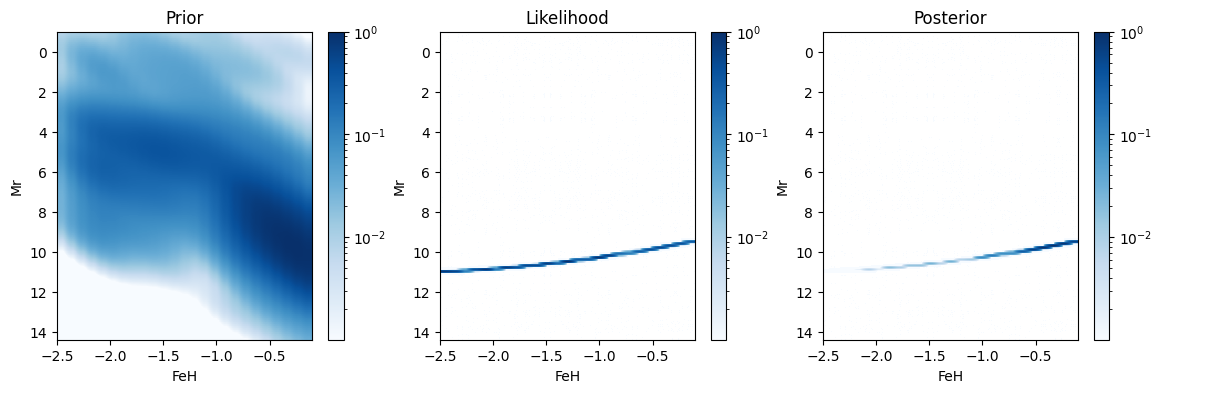

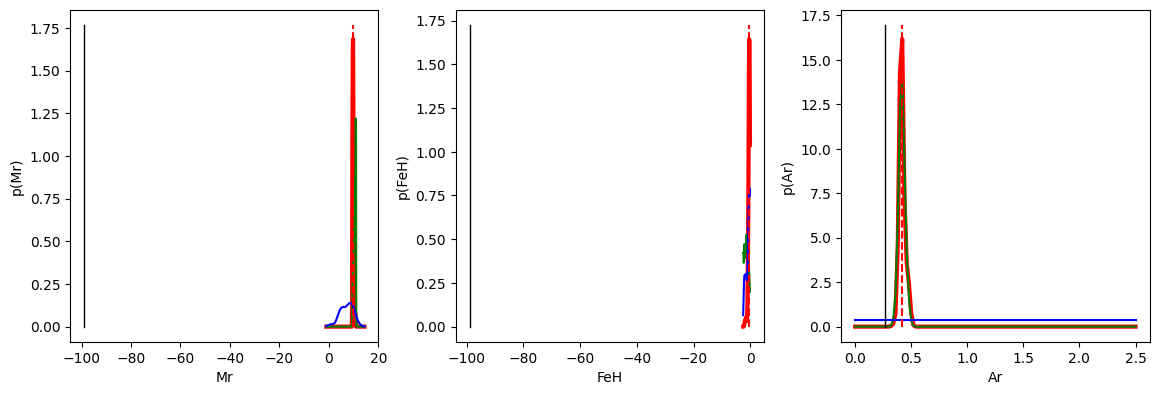

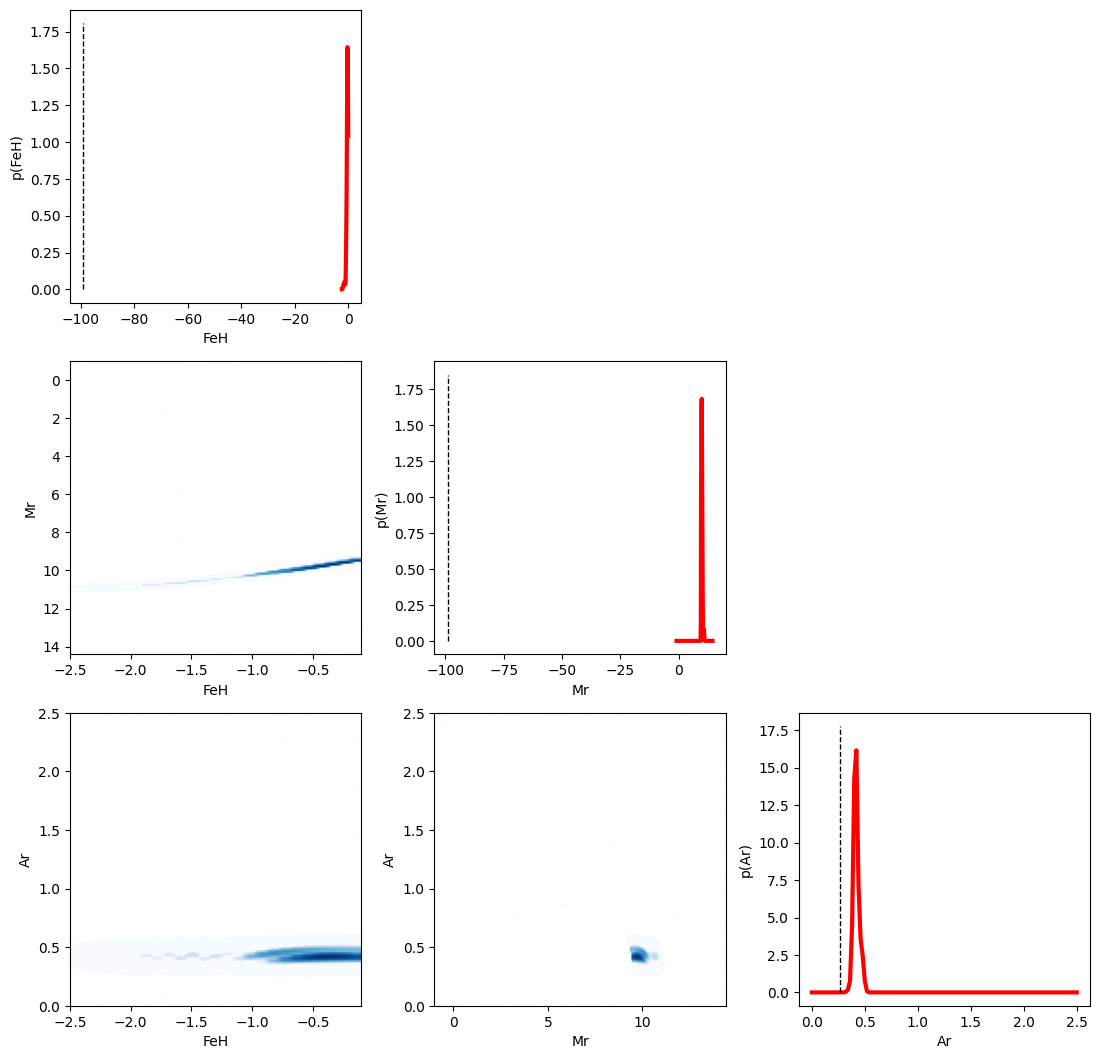

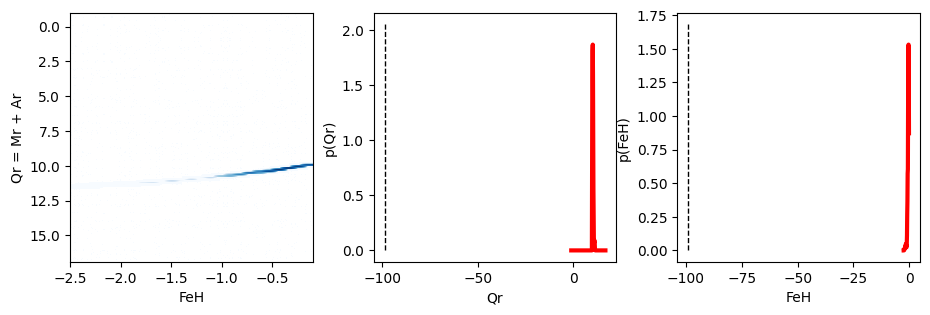

10.286956 0.26310575


In [29]:
from photod.bayes import plotStars

results = computeBayesEstimates(stars_df, prior_map_catalog, globalParams)

for i in range(1):
    plotStars(
        stars_df.iloc[[i]].reset_index(drop=True),
        *results[i].getPlottingArgs(),
        *globalParams.getPlottingArgs(),
        starIndices=[0]
    )

In [23]:
# ############################# #

Mr1d= -1.0 14.4 155
MrBright, MrFaint= -1.0 14.4
Plotting star 0...
pts: 25 155


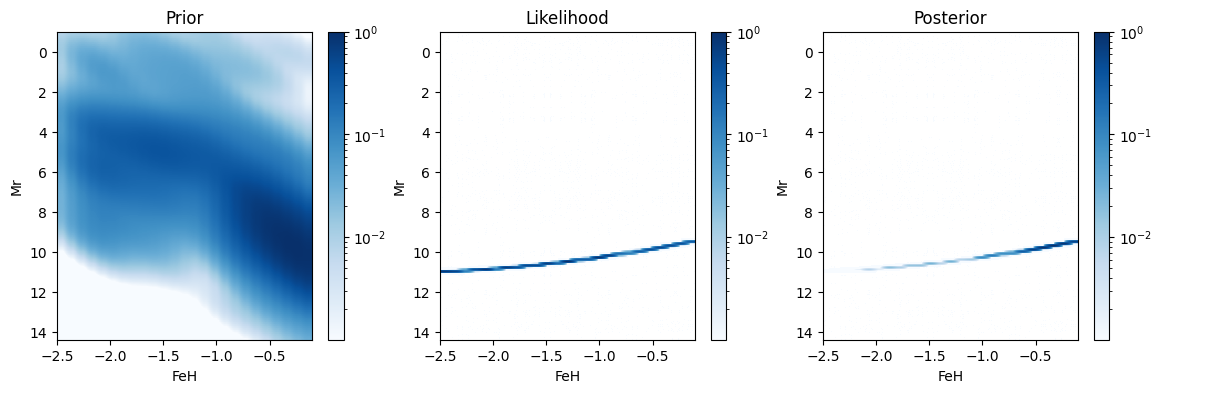

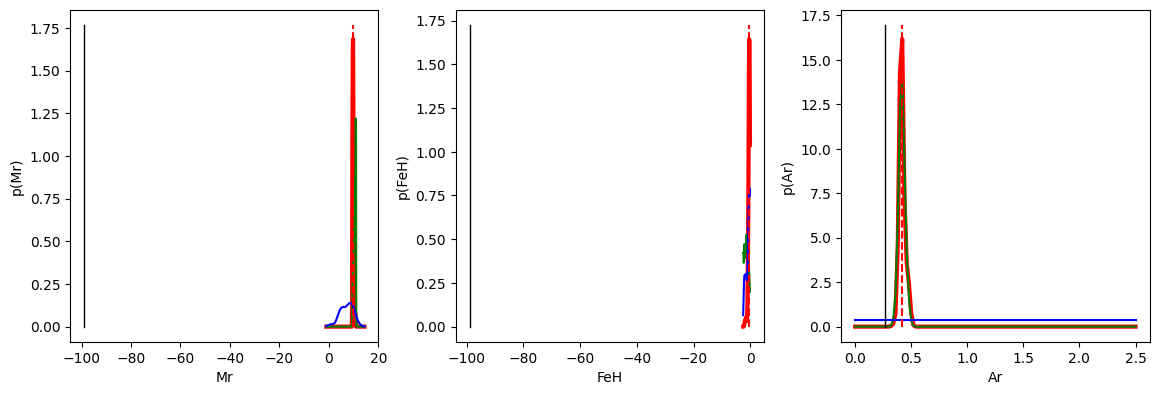

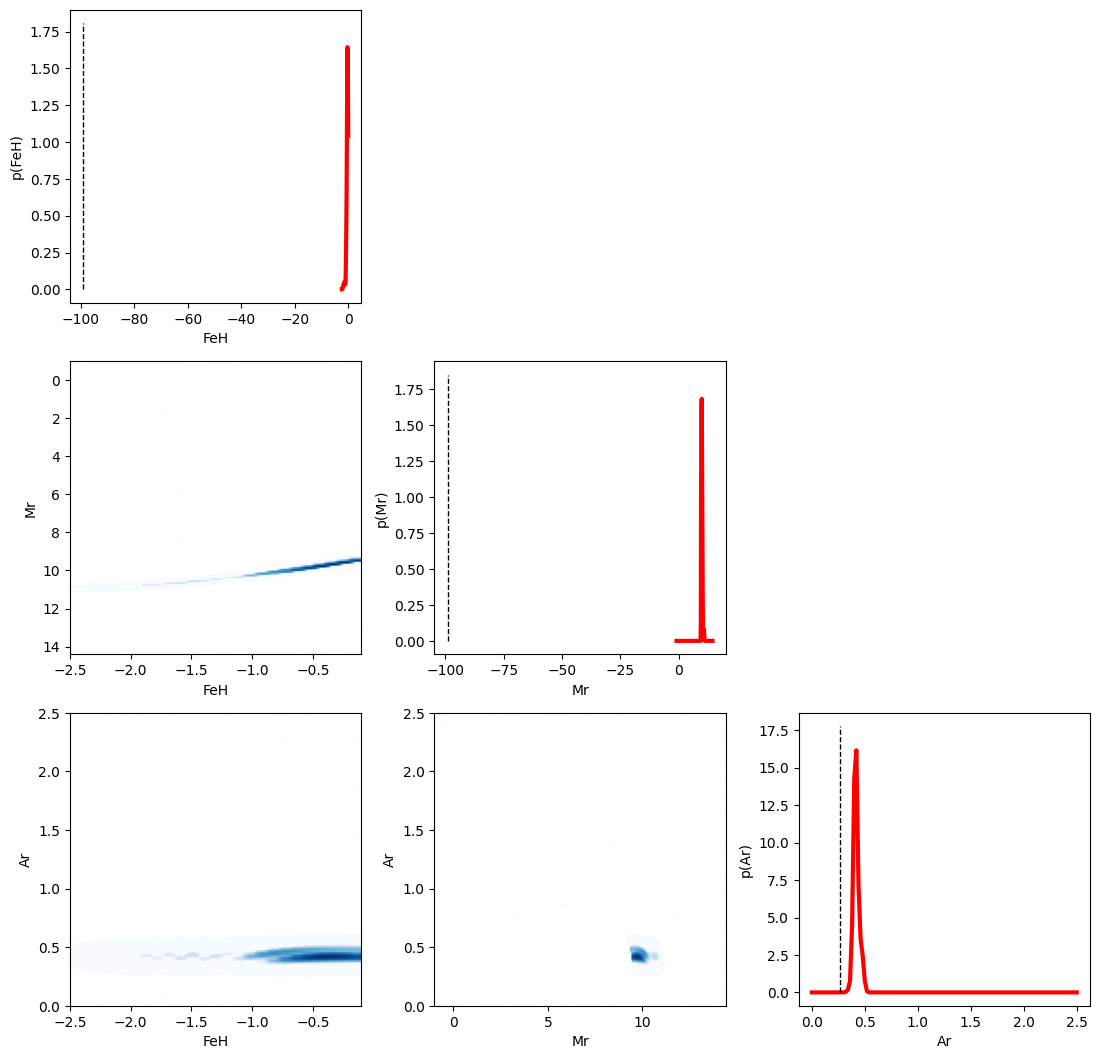

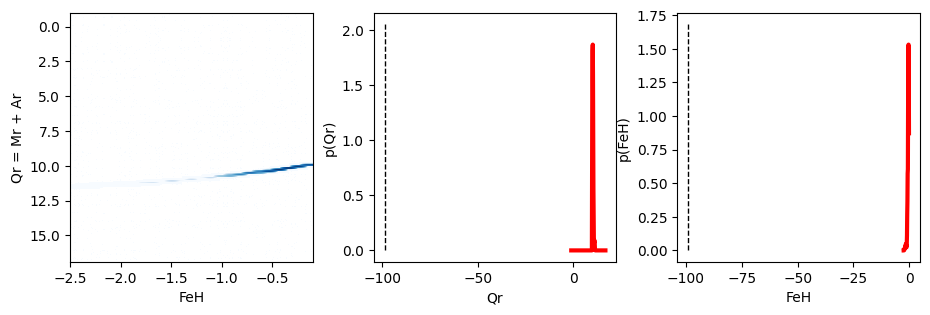

10.286956 0.26310575


In [10]:
from photod.bayes import plotStars

results = computeBayesEstimates(stars_df, prior_map_catalog, globalParams)

for i in range(1):
    plotStars(
        stars_df.iloc[[i]].reset_index(drop=True),
        *results[i].getPlottingArgs(),
        *globalParams.getPlottingArgs(),
        starIndices=[0]
    )

In [11]:
from astropy.coordinates import SkyCoord
coords = SkyCoord(66.68765693, -49.28469218, frame="galactic", unit="deg")
coords.transform_to("icrs").dec.deg

-1.3201242166601415

In [12]:
s82_stripe_catalog.cone_search(coords.transform_to("icrs").ra.deg, coords.transform_to("icrs").dec.deg, 400).compute()["rmag"]

_healpix_29
1326472653693951114    16.523
1326472480719302722    18.993
1326472491862879951    19.191
1326472497843767900    18.722
1326472699452389949    19.967
1326475578172119217    17.621
1326472603063341115     20.08
1326472483007031554    20.876
1326472387318102893    21.115
1326472668191367610    21.473
1326472206228980830    15.699
1326475203861146771    17.454
1326475588439077914    15.134
1326472229830207400    19.409
1326475026681652180    18.122
1326475185000923269    20.716
1326475584040829189    21.154
1326475203332252421    21.293
1326475083014766514    19.613
1326473568554722712    20.199
1326475050256872126    21.213
Name: rmag, dtype: double[pyarrow]

In [13]:
cols = "ra dec glon       glat      comp   logg    FeH      Mr      DM      Ar  rmagObs0   ug     gr     ri     iz    rmag   ugobs   grobs   riobs   izobs   uErr   gErr   rErr   iErr   zErr    ugSL    grSL    riSL    izSL ugErr grErr riErr izErr".split()
vals = "340.0071183860029 -1.3201242166601415 66.68765693 -49.28469218    1    2.40  -0.65    0.42   12.05   0.180   12.66   2.007   0.722   0.280   0.156   12.66   2.081   0.794   0.323   0.191  0.005  0.005  0.005  0.005  0.005   2.081   0.790   0.320   0.196   0.007   0.007   0.007   0.007".split()
df = pd.DataFrame.from_dict({c: [float(v)] for c, v in zip(cols, vals)})
df[["rmag", "ug", "gr", "ri", "iz", "FeH", "Mr"]]

,rmag,ug,gr,ri,iz,FeH,Mr
0,12.66,2.007,0.722,0.28,0.156,-0.65,0.42


Mr1d= -1.0 14.4 155
MrBright, MrFaint= -1.0 14.4
Plotting star 0...
pts: 25 155


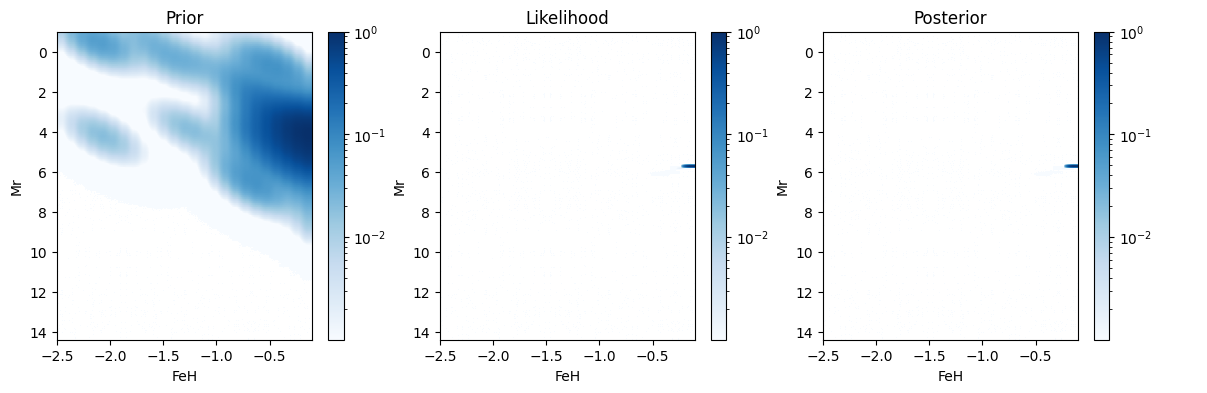

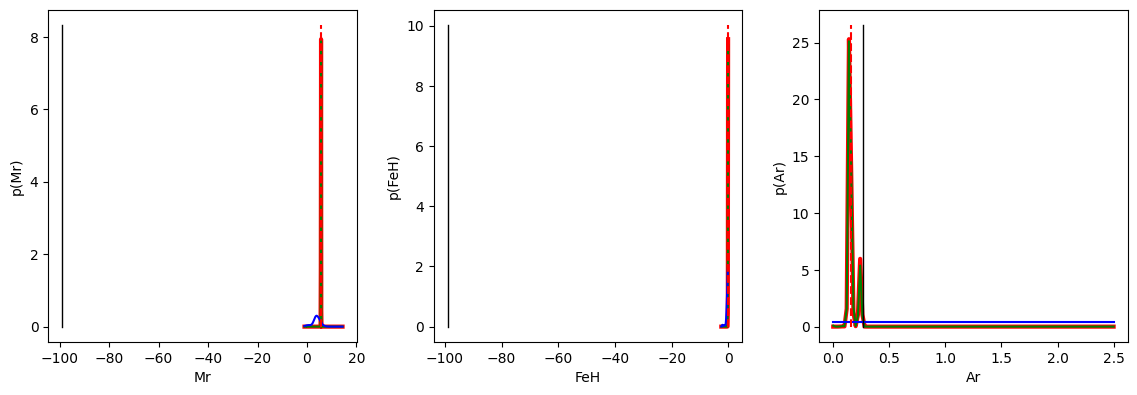

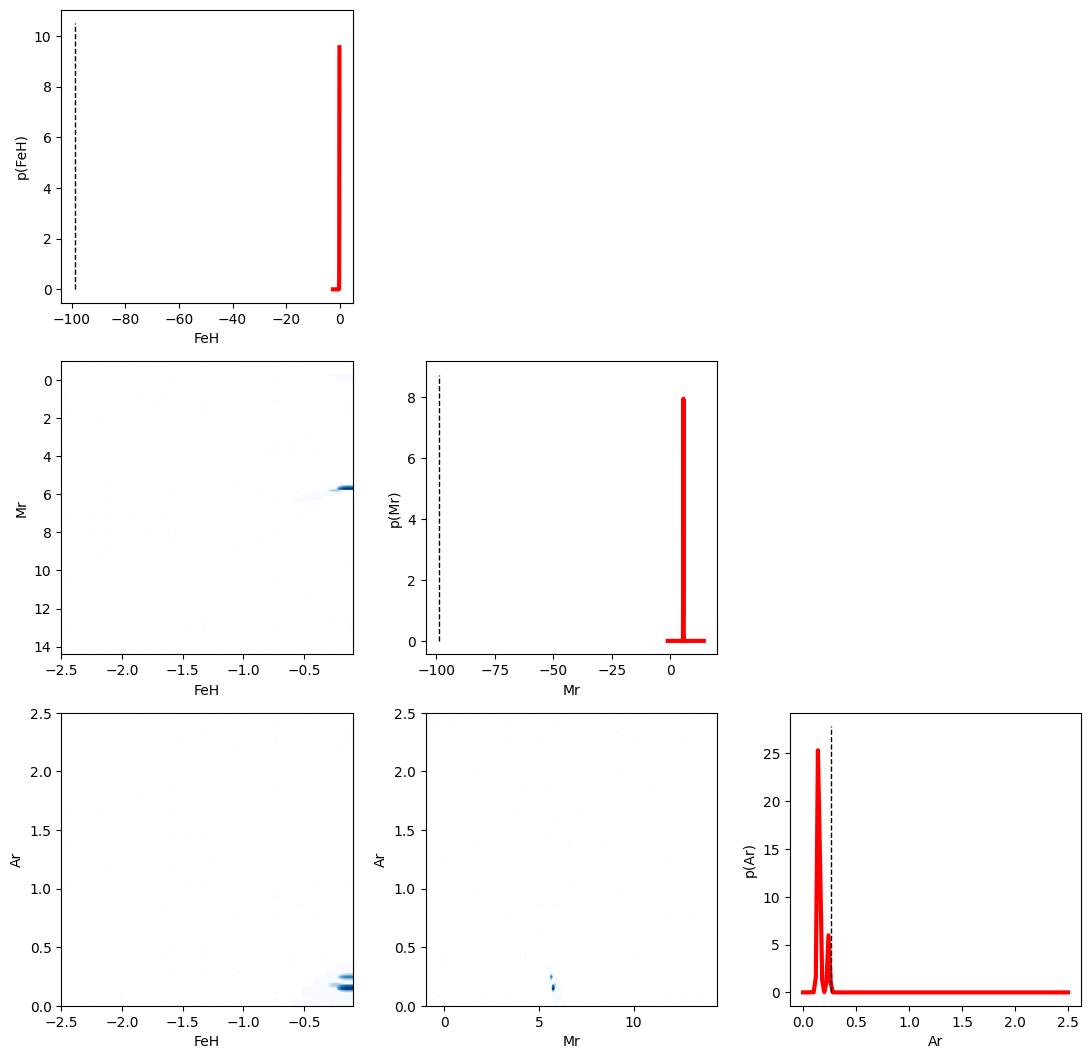

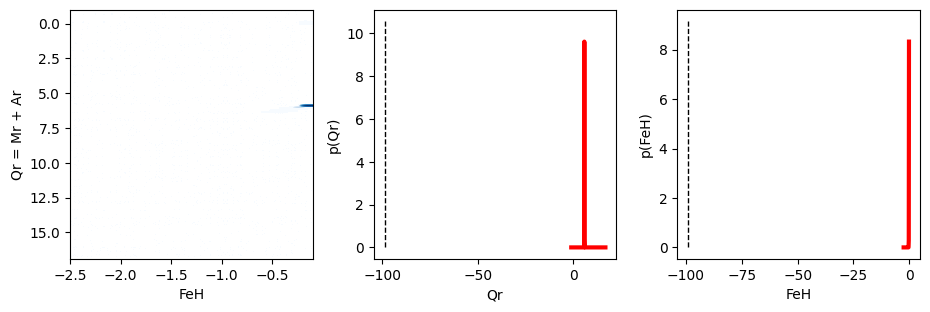

5.862382 0.026382692


In [14]:
from photod.bayes import plotStars

results = computeBayesEstimates(df, prior_map_catalog, globalParams)

plotStars(
    stars_df.iloc[[0]].reset_index(drop=True),
    *results[0].getPlottingArgs(),
    *globalParams.getPlottingArgs(),
    starIndices=[0]
)